In [ ]:
import socket
import pandas as pd
from datetime import datetime as dt
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext as sc
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.catalog import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Pandas settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [ ]:
LOCAL_IP = socket.gethostbyname(socket.gethostname())
spark = (
    SparkSession
    .builder
    .master('k8s://https://10.32.7.103:6443')
    .config('spark.driver.host', LOCAL_IP)
    .config('spark.driver.bindAddress', '0.0.0.0')
    .config('spark.executor.instances', '2')
    .config('spark.executor.cores', '2')
    .config('spark.cores.max', '4')
    .config('spark.executor.memory', '4g')
    #.config('spark.sql.execution.arrow.enabled', 'true')
    .config('spark.kubernetes.namespace', 'juumnov-338467')
    .config('spark.kubernetes.container.image', 'node03.st:5000/spark-executor:juumnov-338467')
    .config('spark.kubernetes.container.image.pullPolicy', 'Always')
    .config('spark.kubernetes.executor.deleteOnTermination', 'false')
    .getOrCreate()
)

In [ ]:
# For checking
!hdfs dfs -ls /tmp/agalin-335417/ibd_data/posts

Found 13 items
-rw-r--r--   3 agalin-335417 supergroup   91289802 2022-06-26 14:01 /tmp/agalin-335417/ibd_data/posts/posts_1tv.parquet
-rw-r--r--   3 agalin-335417 supergroup  101119380 2022-06-26 14:04 /tmp/agalin-335417/ibd_data/posts/posts_lentach.parquet
-rw-r--r--   3 agalin-335417 supergroup  216703435 2022-06-27 00:54 /tmp/agalin-335417/ibd_data/posts/posts_life.parquet
-rw-r--r--   3 agalin-335417 supergroup   27474132 2022-06-26 22:16 /tmp/agalin-335417/ibd_data/posts/posts_mash.parquet
-rw-r--r--   3 agalin-335417 supergroup  104658861 2022-06-26 18:42 /tmp/agalin-335417/ibd_data/posts/posts_meduza.parquet
-rw-r--r--   3 agalin-335417 supergroup   85278321 2022-06-26 20:33 /tmp/agalin-335417/ibd_data/posts/posts_plohienov.parquet
-rw-r--r--   3 agalin-335417 supergroup  123844043 2022-06-26 20:36 /tmp/agalin-335417/ibd_data/posts/posts_rentv.parquet
-rw-r--r--   3 agalin-335417 supergroup  216554917 2022-06-26 20:42 /tmp/agalin-335417/ibd_data/posts/posts_ria.parquet
-rw-r--r

### Function for saving results

In [ ]:
# This function is useful for saving stages results if it is needed to use them in the further work
def save_parquet(data, name):
    file_name = '/tmp/juumnov-338467/Course_project_results/' + name
    start_time = dt.now()
    data.write.parquet(file_name, mode = 'overwrite')
    print('>>>>>> file: ' + file_name + ' >>> time: ' + str(dt.now() - start_time))
    data = spark.read.parquet(file_name)

### Read and union all neccessary data

In [ ]:
def get_data():
    posts = spark.createDataFrame([], spark.read.parquet("hdfs:///tmp/agalin-335417/ibd_data/posts/rbk_posts_parquet.parquet").drop('attachments','copy_history','comments','copyright').schema)
    comments = spark.createDataFrame([], spark.read.parquet("hdfs:///tmp/agalin-335417/ibd_data/comments/users_friends_sent_rbk.parquet").schema)
    users = spark.createDataFrame([], spark.read.parquet("hdfs:///tmp/agalin-335417/ibd_data/users/rbk_users_friends_parquet.parquet").schema)

    path_posts = !hdfs dfs -ls /tmp/agalin-335417/ibd_data/posts
    for i in path_posts[6:]:
        posts = posts.union(spark.read.parquet('hdfs:///' + i.split(' ')[-1]).drop('attachments','copy_history','comments','copyright'))
    path_comments = !hdfs dfs -ls /tmp/agalin-335417/ibd_data/comments
    for i in path_comments[6:]:
        comments = comments.union(spark.read.parquet('hdfs:///' + i.split(' ')[-1]))
    path_users = !hdfs dfs -ls /tmp/agalin-335417/ibd_data/users
    for i in path_users[6:]:
        users = users.union(spark.read.parquet('hdfs:///' + i.split(' ')[-1]))
   
    return posts, comments, users

In [ ]:
posts, comments, users = get_data()

In [ ]:
# Remove deplicates from users by profile ids
users = users.dropDuplicates(['id'])

In [ ]:
names = spark.read.parquet("hdfs:///tmp/agalin-335417/ibd_data/CIS_names_parquet.parquet")

In [ ]:
posts.limit(3).toPandas()

,id,owner_id,from_id,created_by,date,text,reply_post_id,reply_owner_id,likes,reposts,post_type
0,2862067,-25380626,-25380626,NaN,1646227305,Первый канал — в прямом эфире ⬇,NaN,NaN,"(1, 1, 3672, 0)","(835, 0)",post
1,2943800,-25380626,-25380626,NaN,1656169380,К 110-летию со дня рождения Сергея Филиппова ❤...,NaN,NaN,"(1, 1, 105, 0)","(5, 0)",post
2,2943765,-25380626,-25380626,NaN,1656162180,"Лига Бокса\nСуббота, 25 июня\nИнтерконтинентал...",NaN,NaN,"(1, 1, 21, 0)","(3, 0)",post


In [ ]:
comments.limit(3).toPandas()

,date,from_id,id,owner_id,post_id,text,prediction
0,1646228423,134948776,2862090,-25380626,2862067,Эти придурки уже взламывают аптечные приложени...,neutral
1,1646228427,162828015,2862091,-25380626,2862067,Это надо всё ОСТАНОВИТЬ мирным путём !!!,negative
2,1646229306,4463147,2862103,-25380626,2862067,"Фейсбук заблокировал меня сразу же, как только...",neutral


In [ ]:
users.limit(3).toPandas()

,id,private,friends,subscriptions,first_name,last_name,blacklisted,country,education,followers_count,has_photo,home_town,interests,has_mobile,occupation,religion,inspired_by,langs,political,verified,career,deactivated,is_closed
0,25084,0,"[14075, 14634, 14845, 21860, 23678, 57929, 751...","[22741624, 29369324, 88084325, 30525261, 41807...",Eduard,Boytsov,0.0,"(1, Russia)",NaN,1114.0,1,𝓢𝓐𝓘𝓝𝓣-𝓟𝓔𝓣𝓔𝓡𝓢𝓑𝓤𝓡𝓖,,1.0,"(None, None, None, 45301852, LEX - Ваша особая...",NaN,NaN,NaN,NaN,0.0,"[(2, None, 1, None, 36589976, IT, None), (None...",None,False
1,35323,0,None,None,Anatoly,Umerenkov,0.0,"(1, Russia)",NaN,NaN,1,None,None,1.0,"(None, None, None, None, Психиатрическая больн...",NaN,NaN,NaN,NaN,0.0,None,None,True
2,50287,0,None,None,Kristina,Alexandrova,0.0,"(1, Russia)",NaN,NaN,1,None,None,1.0,"(None, None, None, 58727144, ЦБ РФ Центральный...",NaN,NaN,NaN,NaN,0.0,None,None,True


### Users types

In [ ]:
users_opened = users.filter(col('is_closed') == False)
users_closed = users.filter(col('is_closed') == True)

In [ ]:
users_banned = users.filter(col('deactivated') == 'banned')
users_deleted = users.filter(col('deactivated') == 'deleted')
users_verified = users.filter(col('verified') == 1)
users_unverified = users.filter(col('verified') == 0)

In [ ]:
n_unique = users.count()
n_opened = users_opened.count()
n_closed = users_closed.count()
n_banned = users_banned.count()
n_deleted = users_deleted.count()
n_verified = users_verified.count()
n_unverified = users_unverified.count()

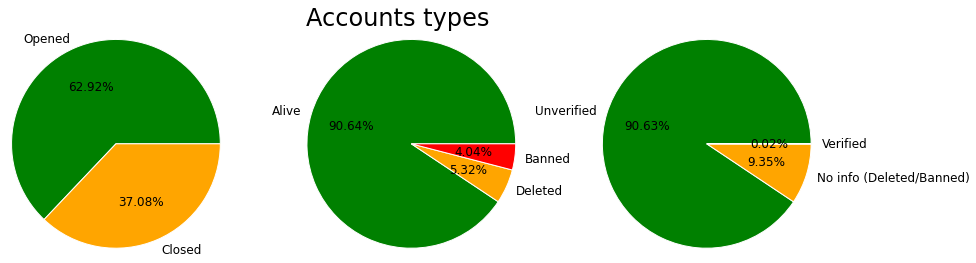

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)
fig.suptitle("Accounts types", fontsize=24)
ax[0].pie([n_opened, n_closed], 
          labels=['Opened', 'Closed'], 
          autopct='%1.2f%%', 
          radius=1.2, 
          wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}, 
          textprops={'size': 12}, 
          colors=['green','orange'])
ax[1].pie([n_unique - n_banned - n_deleted, n_deleted, n_banned], 
          labels=['Alive', 'Deleted', 'Banned'], 
          autopct='%1.2f%%', 
          radius=1.2, 
          wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}, 
          textprops={'size': 12}, 
          colors=['green','orange', 'red'])
ax[2].pie([n_unverified, n_unique - n_verified - n_unverified, n_verified], 
          labels=['Unverified', 'No info (Deleted/Banned)', 'Verified'], 
          autopct='%1.2f%%', 
          radius=1.2, 
          wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}, 
          textprops={'size': 12}, 
          colors=['green','orange', 'red'])
plt.show()

### Data processing

In [ ]:
users_opened_proc = users_opened.withColumn('followers_count', col('followers_count').cast(IntegerType()))\
                                .withColumn('interests', when(col('interests') == '', None).otherwise(col('interests')))\
                                .withColumn('home_town', when(col('home_town') == '', None).otherwise(col('home_town')))\
                                .withColumn('deactivated', when(col('deactivated').isNull(), 'Alive').otherwise(col('deactivated')))\
                                .drop('blacklisted')

### Users comments stats

In [ ]:
users_neg_com_share = comments.groupBy('from_id')\
                              .agg(count(lit(0)).name('n_total'), count(when(col('prediction') == 'negative', True)).name('n_negative'))\
                              .withColumn('neg_share', col('n_negative') / col('n_total'))\
                              .select(col('from_id').name('id'), 'neg_share')

In [ ]:
# For reading if needed data was already obtained
users_neg_com_share = spark.read.parquet('/tmp/juumnov-338467/Course_project_results/users_neg_com_share')

In [ ]:
save_parquet(users_neg_com_share, 'users_neg_com_share')

>>>>>> file: /tmp/juumnov-338467/Course_project_results/users_neg_com_share >>> time: 0:00:10.727572


### Critical points

In [ ]:
users_opened_rp = users_opened_proc.filter(col('friends').isNotNull() & col('subscriptions').isNotNull())\
                                   .filter(~col('deactivated').isin('deleted', 'banned'))\
                                   .filter(col('verified') != 1)\
                                   .withColumn('n_friends', size(col('friends')))\
                                   .withColumn('n_subscriptions', size(col('subscriptions')))\
                                   .withColumn('few_followers', when(col('followers_count') < 10, 1).otherwise(0))\
                                   .withColumn('few_friends', when(col('n_friends') < 10, 1).otherwise(0))\
                                   .withColumn('few_subscriptions', when(col('n_subscriptions') < 10, 1).otherwise(0))\
                                   .withColumn('no_photo', when(col('has_photo') == 0, 1).otherwise(0))\
                                   .withColumn('no_mobile', when(col('has_mobile') == 1, 0).otherwise(1))\
                                   .withColumn('no_town', when(col('home_town').isNull(), 1).otherwise(0))\
                                   .withColumn('no_extended_info', when(col('interests').isNull() 
                                                                        & col('religion').isNull() 
                                                                        & col('country').isNull() 
                                                                        & col('inspired_by').isNull()  
                                                                        & col('political').isNull(), 1).otherwise(0))\
                                   .withColumn('no_prof_info', when(col('education').isNull() 
                                                                    & col('career').isNull() 
                                                                    & col('occupation').isNull(), 1).otherwise(0))\
                                   .withColumn('n_risks', col('few_followers') + col('few_friends') + col('few_subscriptions') + col('no_photo') + col('no_mobile') + col('no_town') + col('no_extended_info') + col('no_prof_info'))

In [ ]:
# For reading if needed data was already obtained
users_opened_rp = spark.read.parquet('/tmp/juumnov-338467/Course_project_results/users_opened_rp')

In [ ]:
save_parquet(users_opened_rp, 'users_opened_rp')

>>>>>> file: /tmp/juumnov-338467/Course_project_results/users_opened_rp >>> time: 0:10:13.791732


In [ ]:
users_opened_risks = users_opened_rp.join(users_neg_com_share, 'id', 'inner')

In [ ]:
percentile_90 = users_opened_risks.groupBy()\
                                  .agg(expr('percentile(n_risks, array(0.90))')[0].alias('%90'))\
                                  .toPandas()['%90']\
                                  .values[0]

In [ ]:
print(percentile_90)

4.0


In [ ]:
# Bots and trolls accounts
bots_trolls = users_opened_risks.filter((col('n_risks') > percentile_90) & (col('neg_share') > 0.5))\
                                .select('id')\
                                .union(users_banned.select('id'))\
                                .distinct()

In [ ]:
# For reading if needed data was already obtained
bots_trolls = spark.read.parquet('/tmp/juumnov-338467/Course_project_results/bots_trolls_ids')

In [ ]:
save_parquet(bots_trolls, 'bots_trolls_ids')

>>>>>> file: /tmp/juumnov-338467/Course_project_results/bots_trolls_ids >>> time: 0:00:19.734535


In [ ]:
# Bots, trolls and banned accounts
bots_trolls_banned = bots_trolls.union(users_banned.select('id'))

In [ ]:
# For reading if needed data was already obtained
bots_trolls_banned = spark.read.parquet('/tmp/juumnov-338467/Course_project_results/bots_trolls_banned_ids')

In [ ]:
save_parquet(bots_trolls_banned, 'bots_trolls_banned_ids')

>>>>>> file: /tmp/juumnov-338467/Course_project_results/bots_trolls_banned_ids >>> time: 0:00:27.787968


In [ ]:
# Find total number of harmful accounts
n_suspect = bots_trolls_banned.count()

In [ ]:
print(f'Total number of harmful accounts = {n_suspect}')
print(f'Share of such acounts = {np.round(n_suspect / n_unique * 100, 1)} %')

Total number of harmful accounts = 129569
Share of such acounts = 8.5 %


### Group with most spam comments

In [ ]:
groups_dict = {'group_name':["1 Канал","Лентач","РБК","Роскомсвобода","Дождь","Вести","Топор","Медуза","РенТВ","Плохие Новости","Life","РИА","Mash"],
               'group_id':[-25380626,-29534144,-25232578,-45023092,-17568841,-24136539,-170528132,-76982440,-26493942,-150709625,-24199209,-15755094,-112510789]}
df = pd.DataFrame(groups_dict)
groups_df = spark.createDataFrame(df)

In [ ]:
groups_df.limit(5).toPandas()

,group_name,group_id
0,1 Канал,-25380626
1,Лентач,-29534144
2,РБК,-25232578
3,Роскомсвобода,-45023092
4,Дождь,-17568841


In [ ]:
# Group with greatest number of spam comments
comments.filter(col('from_id').isin(list(bots_trolls_banned.toPandas()['id'])))\
        .join(groups_df, groups_df.group_id == comments.owner_id, 'inner')\
        .groupBy('group_name')\
        .count()\
        .orderBy(col('count').desc())\
        .limit(1)\
        .toPandas()

,group_name,count
0,РБК,431876


### Top 10 posts with most spam comments

In [ ]:
most_spamful_posts = comments.filter(col('from_id').isin(list(bots_trolls_banned.toPandas()['id'])))\
                             .join(groups_df, groups_df.group_id == comments.owner_id, 'inner')\
                             .groupBy('owner_id', 'post_id')\
                             .count()\
                             .orderBy(col('count').desc())\
                             .limit(10)

In [ ]:
# For reading if needed data was already obtained
most_spamful_posts = spark.read.parquet('/tmp/juumnov-338467/Course_project_results/most_spamful_posts')

In [ ]:
save_parquet(most_spamful_posts, 'most_spamful_posts')

>>>>>> file: /tmp/juumnov-338467/Course_project_results/most_spamful_posts >>> time: 0:04:03.840085


In [ ]:
most_spamful_posts.join(groups_df, groups_df.group_id == most_spamful_posts.owner_id, 'inner')\
                  .select('owner_id','post_id','count','group_name')\
                  .orderBy(col('count').desc())\
                  .toPandas()

,owner_id,post_id,count,group_name
0,-150709625,8236914,377,Плохие Новости
1,-25380626,79652,371,1 Канал
2,-15755094,33153186,370,РИА
3,-150709625,9340121,346,Плохие Новости
4,-17568841,6400781,333,Дождь
5,-15755094,33791286,327,РИА
6,-24136539,5898815,317,Вести
7,-25232578,7598678,304,РБК
8,-15755094,32742675,296,РИА
9,-25380626,526951,287,1 Канал


### Groups shares in spam comments

In [ ]:
spam_shares = comments.filter(col('from_id').isin(list(bots_trolls_banned.toPandas()['id'])))\
                      .groupBy('owner_id')\
                      .count()

In [ ]:
# For reading if needed data was already obtained
spam_shares = spark.read.parquet('/tmp/juumnov-338467/Course_project_results/spam_shares')

In [ ]:
save_parquet(spam_shares, 'spam_shares')

>>>>>> file: /tmp/juumnov-338467/Course_project_results/spam_shares >>> time: 0:05:59.269751


In [ ]:
spam_shares = spam_shares.join(groups_df, groups_df.group_id == spam_shares.owner_id, 'inner')

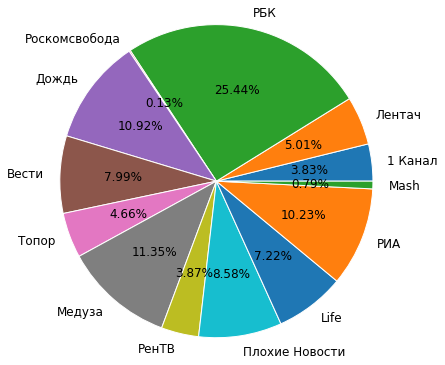

In [ ]:
plt.figure(figsize=(8,6))
plt.pie(list(spam_shares.toPandas()['count']), 
        labels=list(spam_shares.toPandas()['group_name']), 
        autopct='%1.2f%%', 
        radius=1.2, 
        wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}, 
        textprops={'size': 12})
plt.show()

### Groups comparison

In [ ]:
groups_len = comments.groupBy('owner_id')\
                     .count()

In [ ]:
groups_len = groups_len.join(groups_df, groups_df.group_id == groups_len.owner_id, 'inner')

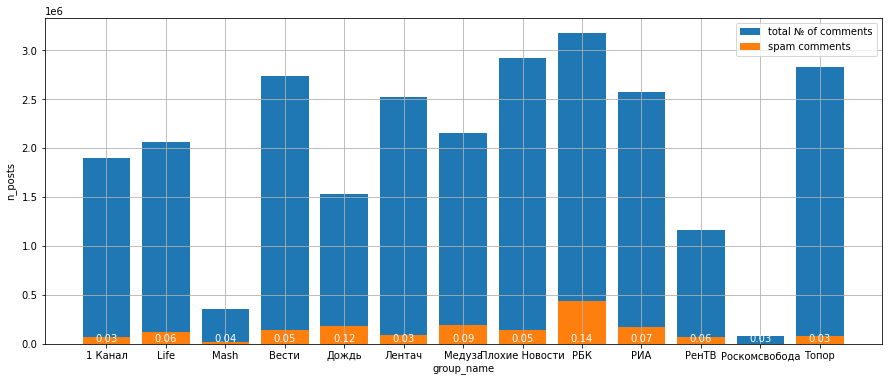

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.bar(list(spam_shares.orderBy('group_name').toPandas()['group_name']), list(groups_len.orderBy('group_name').toPandas()['count']), label='total № of comments')
ax.bar(list(spam_shares.orderBy('group_name').toPandas()['group_name']), list(spam_shares.orderBy('group_name').toPandas()['count']), label='spam comments')
plt.xlabel('group_name')
plt.ylabel('n_posts')
plt.legend()
for i in range(13):
    plt.annotate(str(np.round(list(spam_shares.orderBy('group_name').toPandas()['count'])[i] / list(groups_len.orderBy('group_name').toPandas()['count'])[i], 2)), xy=(list(spam_shares.orderBy('group_name').toPandas()['group_name'])[i],
                             np.round(list(spam_shares.orderBy('group_name').toPandas()['count'])[i] / list(groups_len.orderBy('group_name').toPandas()['count'])[i], 2)), color='white', ha='center', va='bottom')
plt.grid()
plt.legend()
plt.show()